# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:,.2f}'.format)
sns.set(rc={'figure.figsize':(17,5)})

Считываем файл исходных данных в переменные `data_0`, `data_1` и `data_2`

In [2]:
data_0 = pd.read_csv('.\\datasets\\geo_data_0.csv')
data_1 = pd.read_csv('.\\datasets\\geo_data_1.csv')
data_2 = pd.read_csv('.\\datasets\\geo_data_2.csv')

In [3]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [4]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Описание данных в соответствии с заданием (для сведения):**
- **id** — уникальный идентификатор скважины;
- **f0**, **f1**, **f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
- **product** — объём запасов в скважине (тыс. баррелей).

Построим гистограммы для визуального осмотра данных

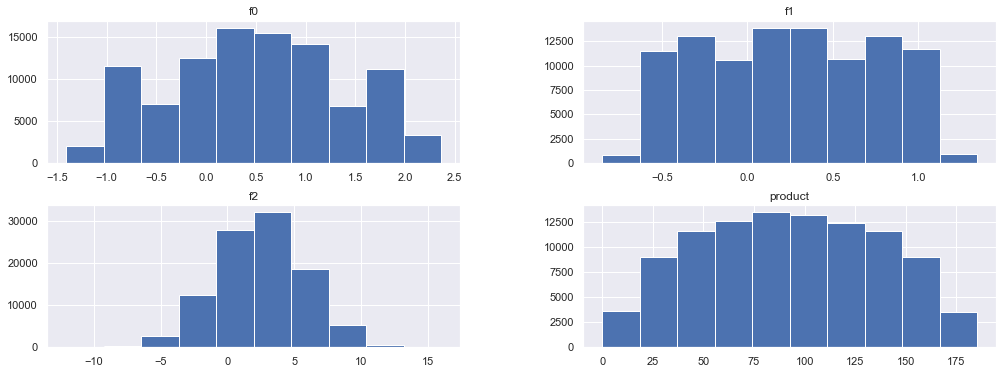

In [5]:
data_0.hist(figsize=(17,6))
plt.show()

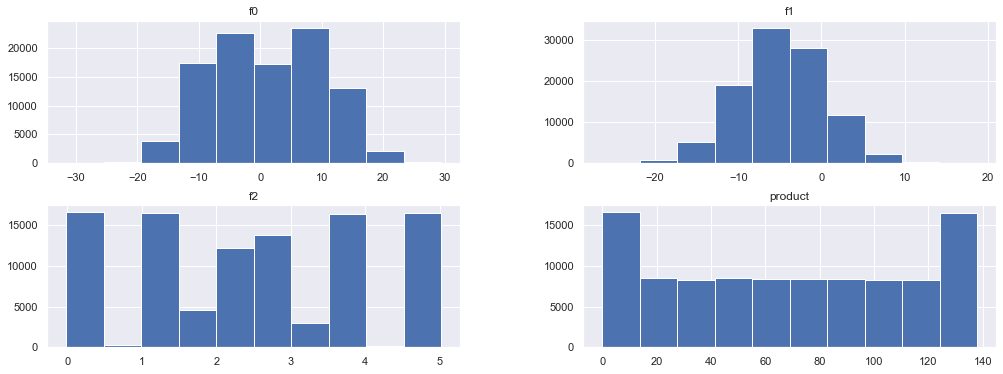

In [6]:
data_1.hist(figsize=(17,6))
plt.show()

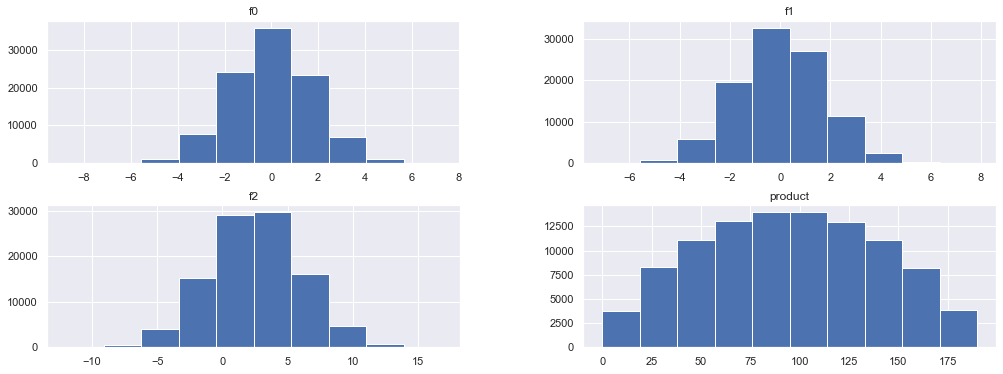

In [7]:
data_2.hist(figsize=(17,6))
plt.show()

В результатах осмотра выявлено нетипичное распределение значений признака `f2` в данных второго региона `data_1`, лля дополнительного уточнения построим матрицу корреляции.

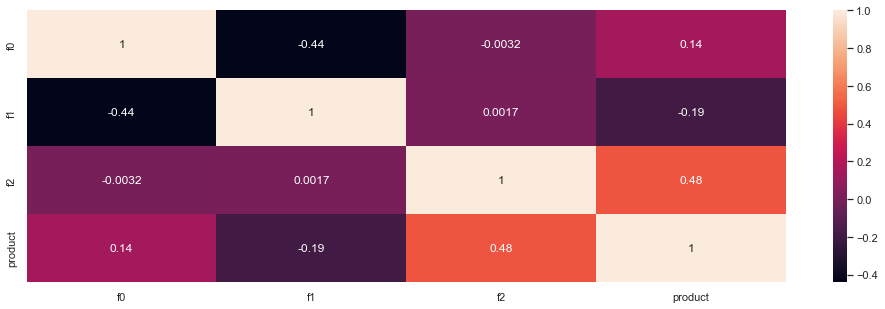

In [8]:
sns.heatmap(data_0.corr(), annot=True)
plt.show()

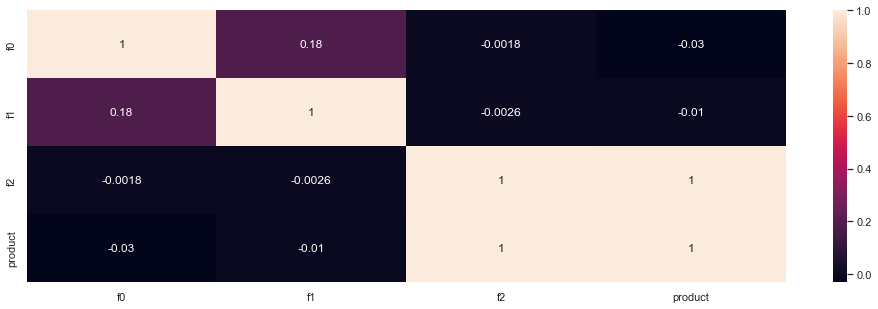

In [9]:
sns.heatmap(data_1.corr(), annot=True)
plt.show()

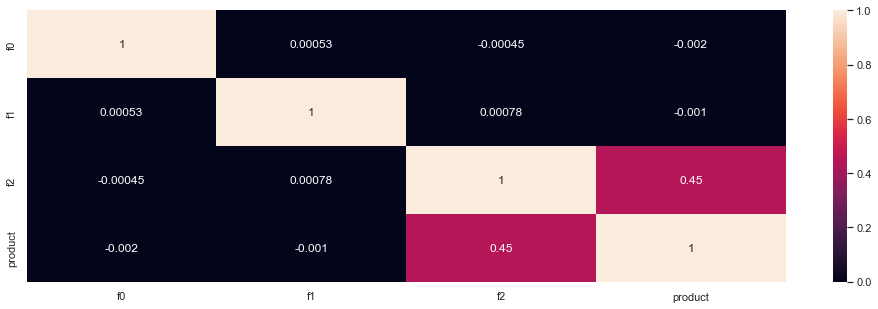

In [10]:
sns.heatmap(data_2.corr(), annot=True)
plt.show()

Дополнительно проверим на наличие дубликатов

In [11]:
print('Дубликатов в data_0:', data_0.duplicated().sum())
print('Дубликатов в data_1:', data_1.duplicated().sum())
print('Дубликатов в data_2:', data_2.duplicated().sum())

Дубликатов в data_0: 0
Дубликатов в data_1: 0
Дубликатов в data_2: 0


Дубликаты отсутствуют

### Вывод

Данные представленные для работы являются полными, без пропусков и дубликатов, но набор данных второго региона (`data_1`) содержит признаки **data** **leakage** (утечки данных), так как есть прямая корелляция между признаком `f2` и искомым признаком `product`, в связи с чем, модель обученная на этих данных не будет верно работать.

## Обучение и проверка модели

### Выделение обучающей и валидационной выборки.


Разделим данные на таблицы с признаками `f0`, `f1`, `f2` и искомым признаком `product`

In [12]:
X_0 = data_0[['f0', 'f1', 'f2']].copy()
y_0 = data_0[['product']].copy()

X_1 = data_1[['f0', 'f1', 'f2']].copy()
y_1 = data_1[['product']].copy()

X_2 = data_2[['f0', 'f1', 'f2']].copy()
y_2 = data_2[['product']].copy()

Выделим обучающую и валидационыне выборки в соотношении 75:25

In [13]:
X_0_train, X_0_valid, y_0_train, y_0_valid = train_test_split(X_0, y_0, test_size=0.25, random_state=13)
X_1_train, X_1_valid, y_1_train, y_1_valid = train_test_split(X_1, y_1, test_size=0.25, random_state=13)
X_2_train, X_2_valid, y_2_train, y_2_valid = train_test_split(X_2, y_2, test_size=0.25, random_state=13)

Проверим размер на паре из этих выборок:

In [14]:
print('Обучающая выборка:', X_0_train.shape[0])
print('Валидационная выборка:', X_0_valid.shape[0])

Обучающая выборка: 75000
Валидационная выборка: 25000


Отмасштабируем признаки с использованием `StandardScaler()`, для оценки результата сохраним одну из таблиц отдельно:

In [15]:
X_0_unscaled = X_0_train.copy()

И воспользуемся `StandardScaler()`:

In [16]:
col_names = ['f0', 'f1', 'f2']

scaler = StandardScaler().fit(X_0_train[col_names].values)

X_0_train[col_names] = scaler.transform(X_0_train[col_names].values)
X_0_valid[col_names] = scaler.transform(X_0_valid[col_names].values)

scaler = StandardScaler().fit(X_1_train[col_names].values)

X_1_train[col_names] = scaler.transform(X_1_train[col_names].values)
X_1_valid[col_names] = scaler.transform(X_1_valid[col_names].values)

scaler = StandardScaler().fit(X_2_train[col_names].values)

X_2_train[col_names] = scaler.transform(X_2_train[col_names].values)
X_2_valid[col_names] = scaler.transform(X_2_valid[col_names].values)

Оценим полученный результат в графическом виде (в виде гистограмм)

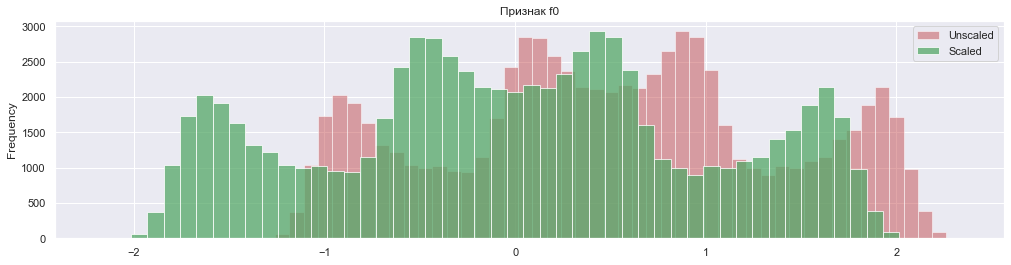

In [17]:
ax = X_0_unscaled.plot(
    kind='hist',
    y='f0',
    bins=50,
    color="r",
    alpha=0.5,
    title='Признак f0',
    grid=True,
    figsize=(17,4)
)

bx = X_0_train.plot(
    kind='hist',
    y='f0',
    bins=50,
    color="g",
    alpha=0.75,
    ax=ax,
    figsize=(17,4)
)
ax.legend(['Unscaled', 'Scaled']) 
plt.show()

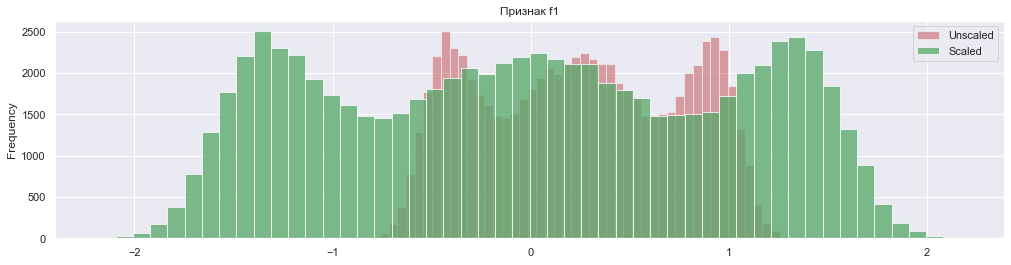

In [18]:
ax = X_0_unscaled.plot(
    kind='hist',
    y='f1',
    bins=50,
    color="r",
    alpha=0.5,
    title='Признак f1',
    grid=True,
    figsize=(17,4)
)

bx = X_0_train.plot(
    kind='hist',
    y='f1',
    bins=50,
    color="g",
    alpha=0.75,
    ax=ax,
    figsize=(17,4)
)
ax.legend(['Unscaled', 'Scaled']) 
plt.show()

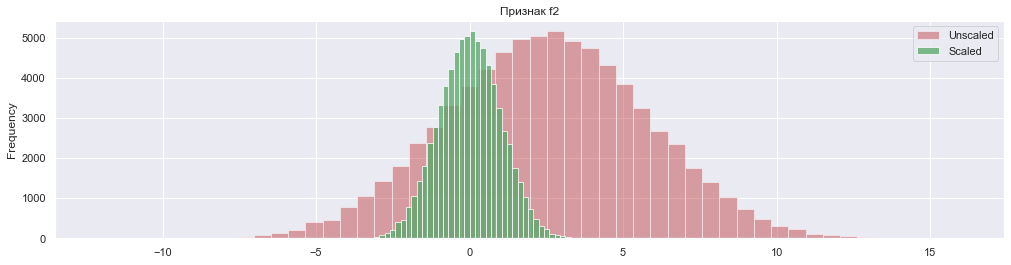

In [19]:
ax = X_0_unscaled.plot(
    kind='hist',
    y='f2',
    bins=50,
    color="r",
    alpha=0.5,
    title='Признак f2',
    grid=True,
    figsize=(17,4)
)

bx = X_0_train.plot(
    kind='hist',
    y='f2',
    bins=50,
    color="g",
    alpha=0.75,
    ax=ax,
    figsize=(17,4)
)
ax.legend(['Unscaled', 'Scaled']) 
plt.show()

Масштабирование признаков прошло успешно

### Обучение модели и предсказание на валидационной выборке.

Воспользуемся моделью `LinearRegression`, для чего сначала обучим её на тренировочной выборке:

In [20]:
model_0 = LinearRegression().fit(X_0_train, y_0_train)
model_1 = LinearRegression().fit(X_1_train, y_1_train)
model_2 = LinearRegression().fit(X_2_train, y_2_train)

Затем получим предсказания, и сохраним их в отдельных переменных. Для дальнейшей работы будет удобнее, если предсказания будут храниться в формате `pandas.Series`, а не numpy array, являющейся результатом работы модели:

In [21]:
predicted_0 = pd.Series(model_0.predict(X_0_valid)[:,0], index=X_0_valid.index)

predicted_1 = pd.Series(model_1.predict(X_1_valid)[:,0], index=X_1_valid.index)

predicted_2 = pd.Series(model_2.predict(X_2_valid)[:,0], index=X_2_valid.index)

Правильные же ответы хранятся в переменных `y_0_valid`, `y_1_valid` и `y_2_valid`, для единообразия создаим переменные в виде `pandas.Series` вместо `pandas.DataFrame`

In [22]:
target_0 = y_0_valid['product']

target_1 = y_1_valid['product']

target_2 = y_2_valid['product']

### Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

Полученные данные, такие как средний запас по регионам, RMSE модели по этим регионам, сохраним в отдельную таблицу:

In [23]:
result_df = pd.DataFrame(index=['FIRST', 'SECOND', 'THIRD'],
                         columns=['RMSE', 'mean_predict', 'mean_true'])

В которую поместим нужным нам данные о среднепредсказанном количестве сырья:

In [24]:
result_df['mean_predict']['FIRST'] = predicted_0.mean()
result_df['mean_predict']['SECOND'] = predicted_1.mean()
result_df['mean_predict']['THIRD'] = predicted_2.mean()

И о качестве нашей модели в виде метрики `RMSE`

In [25]:
result_df['RMSE']['FIRST'] = mean_squared_error(y_0_valid, predicted_0)**0.5
result_df['RMSE']['SECOND'] = mean_squared_error(y_1_valid, predicted_1)**0.5
result_df['RMSE']['THIRD'] = mean_squared_error(y_2_valid, predicted_2)**0.5

Для сравнения поместим данные о реальном среднем количестве сырья в ту же таблицу:

In [26]:
result_df['mean_true']['FIRST'] = data_0['product'].mean()
result_df['mean_true']['SECOND'] = data_1['product'].mean()
result_df['mean_true']['THIRD'] = data_2['product'].mean()

In [27]:
result_df

,RMSE,mean_predict,mean_true
FIRST,37.69,92.59,92.50
SECOND,0.89,69.03,68.83
THIRD,40.02,94.96,95.00


### Выводы по моделированию.

Моделирование было выполнено с использованием модели `LinearRegression()`:

- Первый и третий регион имеют схожие значения метрики **RMSE** (~40), и схожее среднее значение запаса.
- Второй регион, как и ожидалось, проявил признаки "*утечки* *данных*", и модель работающая с ним показала нереалистично хороший результат со значением метрики **RMSE** близким к нулю.

## Подготовка к расчёту прибыли

В соответствии с условиями поставленной задачи:

- при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- бюджет на разработку скважин в регионе — 10 млрд рублей;
- доход с каждой единицы продукта (1000 баррелей) составляет 450 тыс. рублей;
- требуемая вероятность убытков - меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### Ключевые значения для расчётов

Все расчёты будут производится в тысячах рублей, следовательно бюджет разработки региона составит 10 миллионов тысяч рублей (10 млрд):

In [28]:
BUDGET = 10e6

Доход с одной тысячи баррелей сырья (одной единицы продукта) составляет 450 тыс. рублей, т.е.:

In [29]:
PRODUCT_INCOME = 450

Также укажем в виде переменных такие значения как порог вероятности убытков, равный 2.5%, и количество разрабатываемых скважин:

In [30]:
THRESHOLD = 2.5/100
SELECTED_HOLES = 200
PROBED_HOLES = 500

### Определение достаточного объёма сырья для безубыточной разработки новой скважины.

Достаточный объём сырья для безубыточной разработки новой скважины составляет:

In [31]:
product_needed = BUDGET / (PRODUCT_INCOME * SELECTED_HOLES)
print('Объём сырья для безубыточности разработки скважины: {:.3f}'.format(product_needed))

Объём сырья для безубыточности разработки скважины: 111.111


Сравним это значение со средним значение по регионам и добавим в таблицу `result_df`

In [32]:
result_df['product_short'] = product_needed-result_df['mean_predict']
result_df

,RMSE,mean_predict,mean_true,product_short
FIRST,37.69,92.59,92.50,18.52
SECOND,0.89,69.03,68.83,42.08
THIRD,40.02,94.96,95.00,16.15


**Промежуточный вывод**:

С точки зрения перспективности разработки на данном этапе исследования, наилучший результат показывает **регион №3**, как имеющий наименьшую нехватку объёма сырья для выхода на безубыточность, составляющий ***17%***, в отличие от **региона №1** с недостачей в ***20%*** и **региона №2** с нехваткой в ***60%***, т.е. при неверном выборе скважины в третьем регионе, недостача составит более трети от необходимого, что приведёт к повышенным убыткам.

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:

Напишем функцию `profit`, где:

- принимается на вход:
  - **target** - истинные значения целевого признака;
  - **preds** - предсказания целевого признака;
  - **count** - количество выбираемых скважин, равно переменной `SELECTED_HOLES`
- известные переменные:
  - **SELECTED_HOLES** - 200 лучших скважин, определена ранее в соответствии с исходными данными;
  - **PRODUCT_INCOME** - доход с одной единицы продукта (450 тыс. руб), также по исходным данным;
  - **BUDGET** - бюджет на разработку, по исходным данным.
- результат работы функции - прибыль, в тыс. рублей.

In [33]:
def profit(target, preds, count=SELECTED_HOLES):
    holes_sorted = preds.sort_values(ascending = False).head(count)
    choosen = target[holes_sorted.index]
    return (choosen.sum() * PRODUCT_INCOME) - BUDGET

Протестируем работоспособность функции:

In [34]:
profit(target_0, predicted_0)

3237556.9605991095

### Выводы по этапу.

Также, как и в моделировании, первый и третий регион показали схожие результаты, второй же, при учете только средних значений, выглядит наименее коммерчески выгодным, как имеющий самую большую разницу между требуемым значением и предсказанным средним.

## Расчёт прибыли и рисков 

### Bootstrap для определения распределение прибыли.

Для более удобного применения техники **bootstrap** напишем одноименную функцию, где:

- принимается на вход:
  - **target** - истинные значения целевого признака;
  - **preds** - предсказания целевого признака;
  - **how_much** - количество выборок, равное 1000.
- известные переменные:
  - **PROBED_HOLES** - 500 скважин, подвергающиеся исследованию, в соответствии с исходными данными;
  - **profit** - ранее написанная функция для вычисления прибыли.
- результат работы функции - список средних значений прибыли, в тыс. рублей.

In [35]:
def bootstrap(target, preds, how_much=1000):
    state = np.random.RandomState(13)
    values = []
    for i in range(how_much):
        target_subsample = target.sample(n=PROBED_HOLES, random_state=state, replace=True)
        preds_subsample = preds[target_subsample.index]
        values.append(profit(target_subsample, preds_subsample))
   
    return pd.Series(values)

И применим её для получения результата по регионам:

In [36]:
bs_result_0 = bootstrap(target_0, predicted_0)

bs_result_1 = bootstrap(target_1, predicted_1)

bs_result_2 = bootstrap(target_2, predicted_2)

### Cредняя прибыль, 95%-й доверительный интервал и риск убытков.

Результаты bootstrap, а точнее - среднее значение (среднюю прибыль) поместим в таблицу `result_df`

In [37]:
result_df.loc['FIRST', 'mean_profit'] = bs_result_0.mean()
result_df.loc['SECOND', 'mean_profit'] = bs_result_1.mean()
result_df.loc['THIRD', 'mean_profit']= bs_result_2.mean()

Найдём 95% доверительный интервал для полученных результатов, от 0.025 квантиля (2.5%) снизу до 0.975 квантиля (97.5%) сверху, и занесём эти значения в таблицу:

In [38]:
result_df.loc['FIRST', 'interval_95_low'] = bs_result_0.quantile(0.025)
result_df.loc['FIRST', 'interval_95_high'] = bs_result_0.quantile(0.975)

result_df.loc['SECOND', 'interval_95_low'] = bs_result_1.quantile(0.025)
result_df.loc['SECOND', 'interval_95_high'] = bs_result_1.quantile(0.975)

result_df.loc['THIRD', 'interval_95_low'] = bs_result_2.quantile(0.025)
result_df.loc['THIRD', 'interval_95_high'] = bs_result_2.quantile(0.975)

Определим убытки, как долю отрицательных значений дохода к общему количеству этих значений с добавлением результата в таблицу

In [39]:
result_df.loc['FIRST', 'perc_loss'] = bs_result_0[bs_result_0 < 0].count() / bs_result_0.count()

result_df.loc['SECOND', 'perc_loss'] = bs_result_1[bs_result_1 < 0].count() / bs_result_1.count()

result_df.loc['THIRD', 'perc_loss'] = bs_result_2[bs_result_2 < 0].count() / bs_result_2.count()

И наконец, выведем эту таблицу `result_df` в отформатированном виде:

In [40]:
format_dict = {'RMSE':'{0:.2f}',
               'mean_predict':'{0:.2f}',
               'mean_true':'{0:.2f}',
               'product_short':'{0:.2f}',
               'mean_profit':'{0:,.0f} ₽',
               'interval_95_low':'{0:,.0f} ₽',
               'interval_95_high':'₽{0:,.0f} ₽',
               'perc_loss': '{:.1%}'}
result_df.style.format(format_dict)

,RMSE,mean_predict,mean_true,product_short,mean_profit,interval_95_low,interval_95_high,perc_loss
FIRST,37.69,92.59,92.50,18.52,"655,051 ₽","59,448 ₽","₽1,272,493 ₽",1.8%
SECOND,0.89,69.03,68.83,42.08,"692,598 ₽","219,361 ₽","₽1,222,602 ₽",0.2%
THIRD,40.02,94.96,95.00,16.15,"581,193 ₽","-60,452 ₽","₽1,225,011 ₽",3.9%


### Выводы

Из полученного результата следует (с **наихудшего**):

- **Регион** **№2** - имеет наименьший процент возможных убытков (**0.2%**), что является лишь следствием утечки данных (*data* *leakage*), в случае, если бы данная утечка не имела влияния, и результаты были независимыми, то данный регион имеет наименьшие средние запасы, что приводит к наименьшим реальным прибылям;

- **Регион** **№3** - имеет самый худший процент возможных убытков (**3.9%**), превышающий пороговое значение в 2.5%, следовательно, при этом являясь регионом с самым большим средним значением запасов, но с точик зрения рисков не соответствует целям; 

- **Регион** **№1** - **наилучший** вариант из предложенных, процент возможных убытков в пределах допустимого (**1.8%**), при этом среднее значение запасов сопоставимы с регионом №3, следовательно, именно этот регион рекомендуется к проведению разведки, и дальнешей разработке.